# Image data sets

In [55]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import torch

sys.path.append("../../")
from experiments.datasets import IMDBLoader
from experiments.architectures.image_transforms import create_image_transform, create_image_encoder
from experiments.architectures.vector_transforms import create_vector_transform
from manifold_flow.flows import ManifoldFlow, EncoderManifoldFlow
import plot_settings as ps


In [56]:
ps.setup()

## Helper function to go from torch to numpy conventions

In [57]:
def trf(x):
    return np.clip(np.transpose(x, [1,2,0]) / 256., 0., 1.)

## Load models

In [58]:
def load_model(
    filename,
    outerlayers=20,
    innerlayers=8,
    levels=4,
    splinebins=11,
    splinerange=10.0,
    dropout=0.0,
    actnorm=True,
    batchnorm=False,
    linlayers=2,
    linchannelfactor=2,
    lineartransform="lu"
):
    steps_per_level = outerlayers // levels
    spline_params = {
        "apply_unconditional_transform": False,
        "min_bin_height": 0.001,
        "min_bin_width": 0.001,
        "min_derivative": 0.001,
        "num_bins": splinebins,
        "tail_bound": splinerange,
    }
    outer_transform = create_image_transform(
        3,
        64,
        64,
        levels=levels,
        hidden_channels=100,
        steps_per_level=steps_per_level,
        num_res_blocks=2,
        alpha=0.05,
        num_bits=8,
        preprocessing="glow",
        dropout_prob=dropout,
        multi_scale=True,
        spline_params=spline_params,
        postprocessing="partial_mlp",
        postprocessing_layers=linlayers,
        postprocessing_channel_factor=linchannelfactor,
        use_actnorm=actnorm,
        use_batchnorm=batchnorm,
    )
    inner_transform = create_vector_transform(
        512,
        innerlayers,
        linear_transform_type=lineartransform,
        base_transform_type="rq-coupling",
        context_features=1,
        dropout_probability=dropout,
        tail_bound=splinerange,
        num_bins=splinebins,
        use_batch_norm=batchnorm,
    )
    model = ManifoldFlow(
        data_dim=(3, 64, 64),
        latent_dim=512,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
        pie_epsilon=0.1,
        clip_pie=None
    )
        
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    _ = model.eval()
    
    return model

In [66]:
def load_emf_model(
    filename,
    outerlayers=20,
    innerlayers=8,
    levels=4,
    splinebins=11,
    splinerange=10.0,
    dropout=0.0,
    actnorm=True,
    batchnorm=False,
    linlayers=2,
    linchannelfactor=2,
    lineartransform="lu"
):
    steps_per_level = outerlayers // levels
    spline_params = {
        "apply_unconditional_transform": False,
        "min_bin_height": 0.001,
        "min_bin_width": 0.001,
        "min_derivative": 0.001,
        "num_bins": splinebins,
        "tail_bound": splinerange,
    }
    encoder = create_image_encoder(
        3,
        64,
        64,
        latent_dim=2,
        context_features=None,
    )
    outer_transform = create_image_transform(
        3,
        64,
        64,
        levels=levels,
        hidden_channels=100,
        steps_per_level=steps_per_level,
        num_res_blocks=2,
        alpha=0.05,
        num_bits=8,
        preprocessing="glow",
        dropout_prob=dropout,
        multi_scale=True,
        spline_params=spline_params,
        postprocessing="partial_mlp",
        postprocessing_layers=linlayers,
        postprocessing_channel_factor=linchannelfactor,
        use_actnorm=actnorm,
        use_batchnorm=batchnorm,
    )
    inner_transform = create_vector_transform(
        512,
        innerlayers,
        linear_transform_type=lineartransform,
        base_transform_type="rq-coupling",
        context_features=1,
        dropout_probability=dropout,
        tail_bound=splinerange,
        num_bins=splinebins,
        use_batch_norm=batchnorm,
    )
    model = EncoderManifoldFlow(
        data_dim=(3, 64, 64),
        latent_dim=512,
        encoder=encoder,
        outer_transform=outer_transform,
        inner_transform=inner_transform,
        apply_context_to_outer=False,
        pie_epsilon=0.1,
        clip_pie=None
    )
        
    model.load_state_dict(
        torch.load("../data/models/{}.pt".format(filename), map_location=torch.device("cpu"))
    )
    # _ = model.eval()
    
    return model

In [70]:
mf1 = load_model("checkpoints/mf_512_imdb_april_run10_epoch_A_last")
mf2 = load_model("checkpoints/mf_512_imdb_april_run10_epoch_A_last")
_ = mf2.eval()

## Test samples and projections to learned manifolds

In [73]:
sim = IMDBLoader()
loader = sim.load_dataset(train=True, dataset_dir="../data/samples/imdb")
test_idx=[0,1,2, 3]
n_test = len(test_idx)

x_test = torch.cat([loader[i][0].unsqueeze(0) for i in test_idx], dim=0).to(torch.float)
param_test = torch.cat([torch.tensor(loader[i][1]).unsqueeze(0) for i in test_idx], dim=0).to(torch.float)

x_reco_mf1 = mf1(x_test, context=param_test, mode="projection")[0].detach().numpy()
x_reco_mf1 = mf1(x_test, context=param_test, mode="projection")[0].detach().numpy()
x_reco_mf2 = mf2(x_test, context=param_test, mode="projection")[0].detach().numpy()

x_test = x_test.detach().numpy()


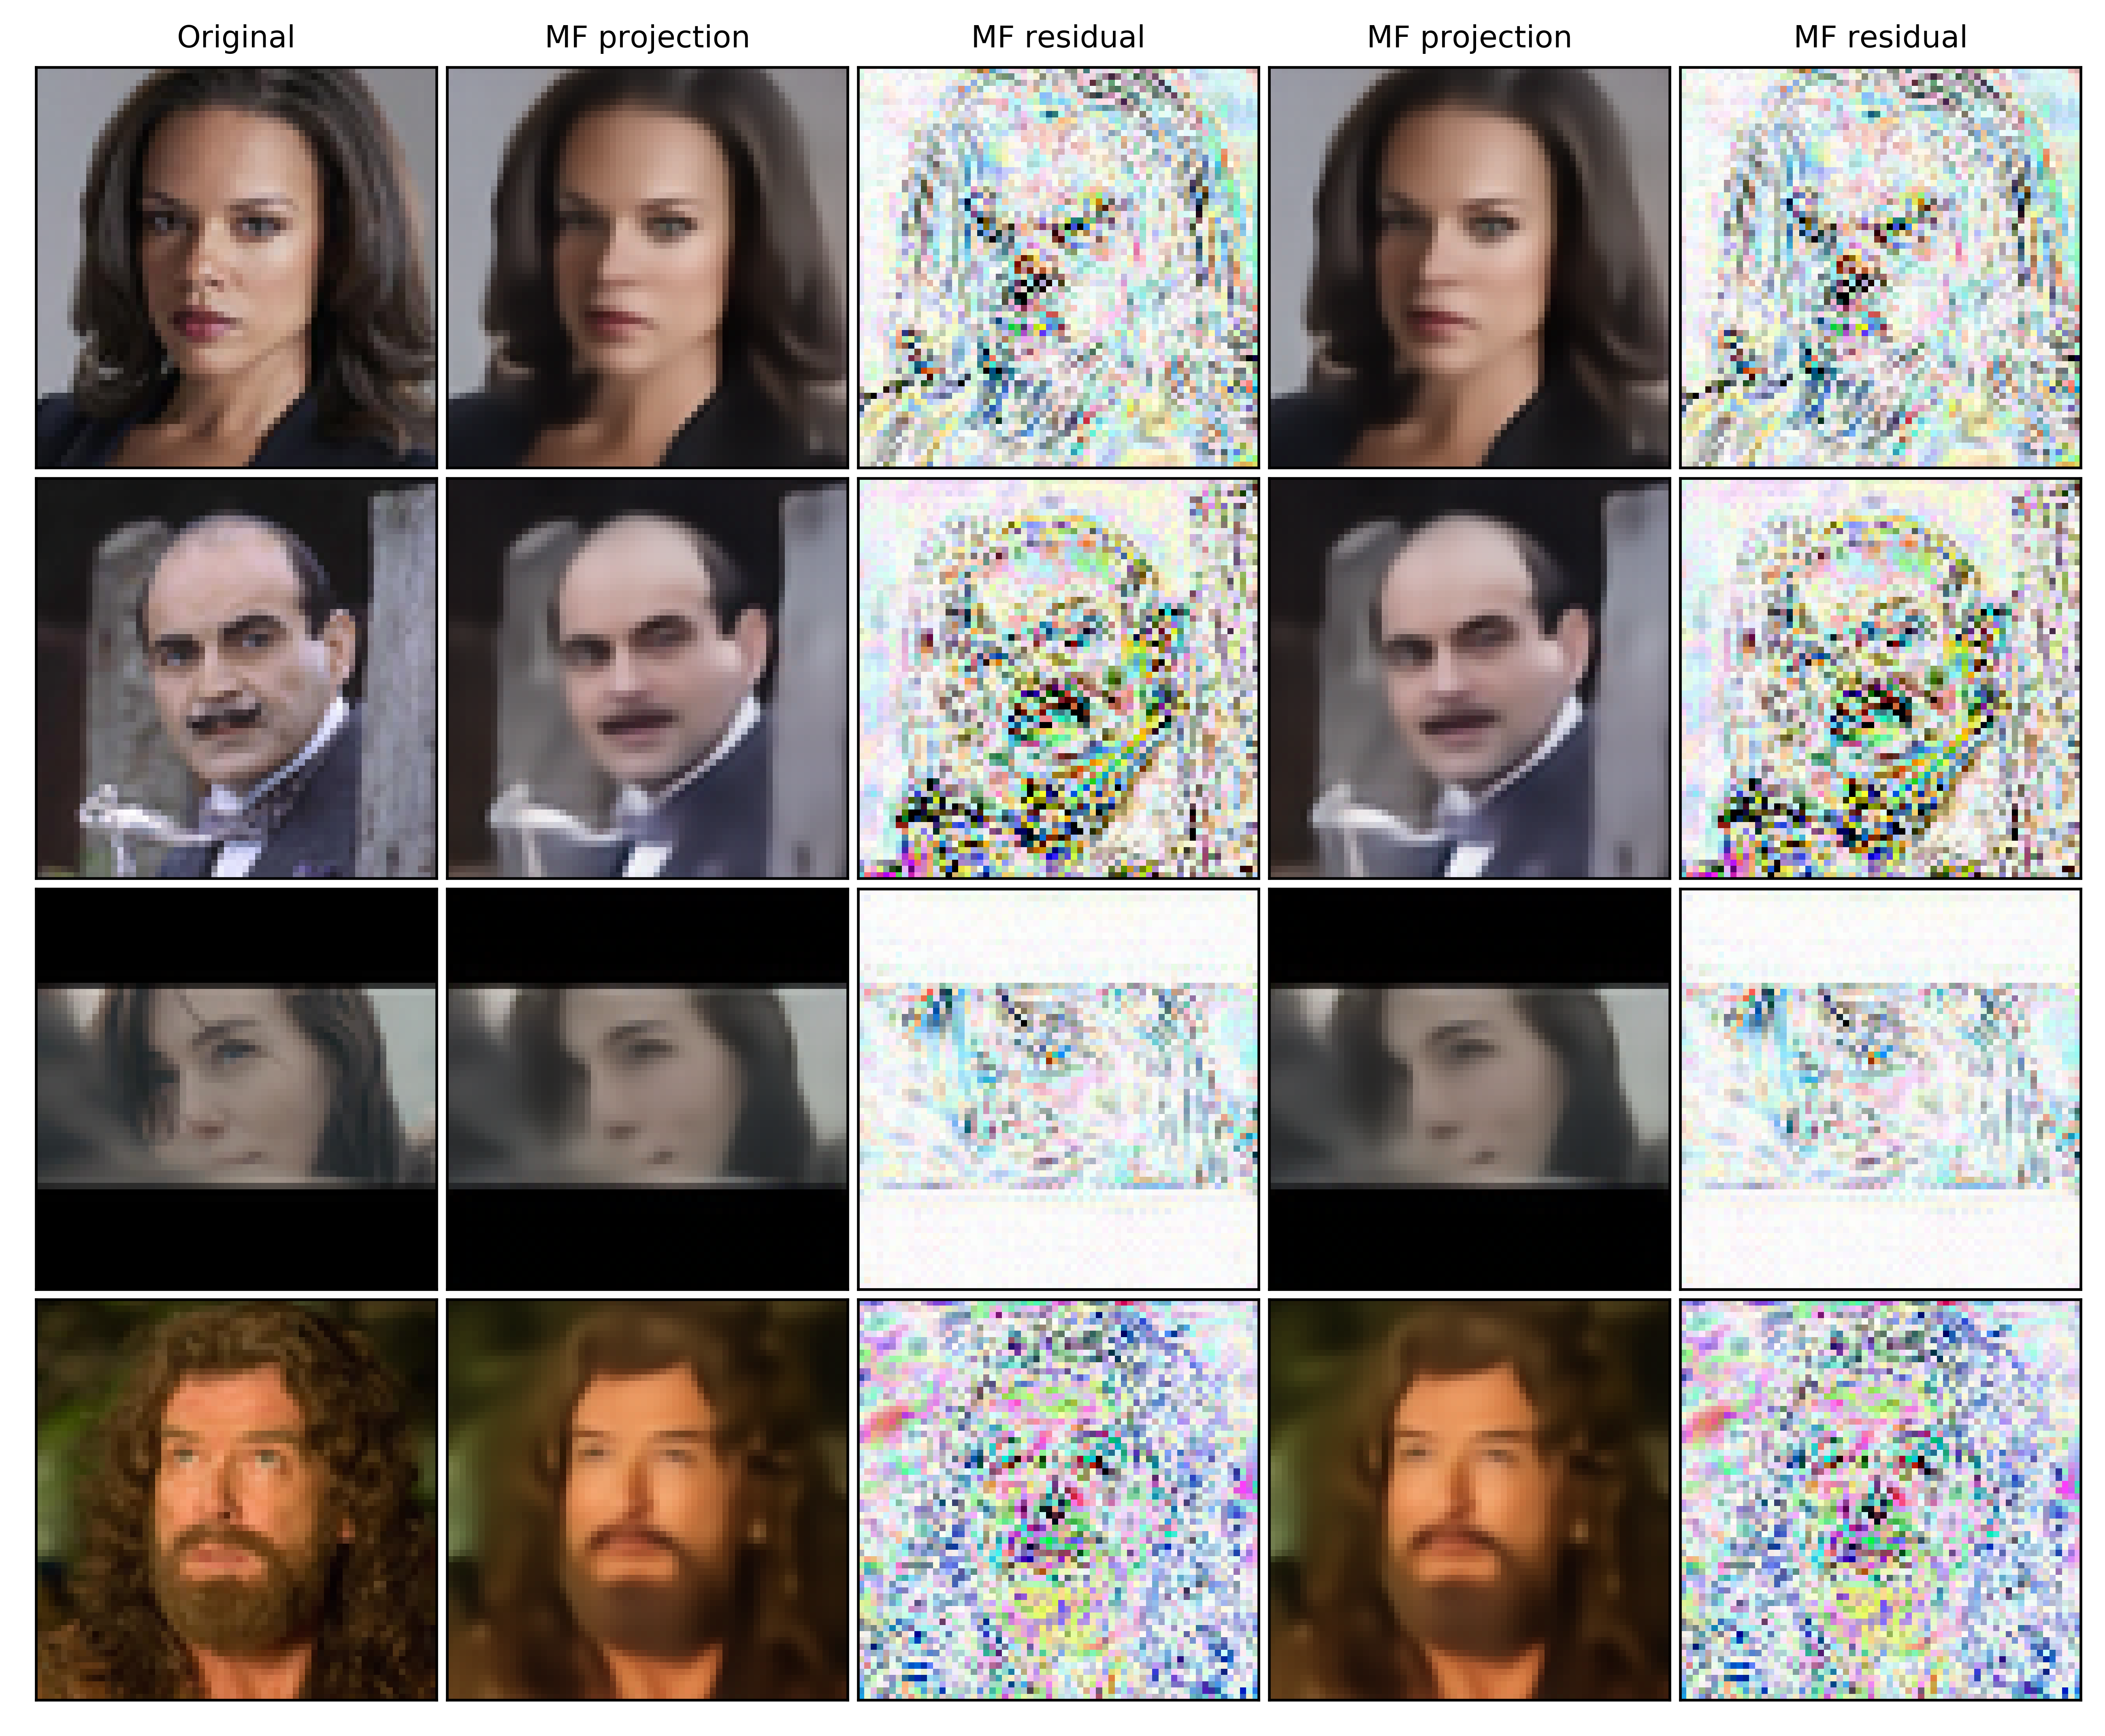

In [74]:
enhance = 10
fig, gs = ps.grid_width(5, n_test, width=ps.TEXTWIDTH, large_margin=0.04, small_margin=0.04, sep=0.005)

for i in range(n_test):
    # Test image
    ax = plt.subplot(gs[i*5 + 0])
    plt.imshow(trf(x_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: plt.title("Original")
    
    # Reco MF
    ax = plt.subplot(gs[i*5 + 1])
    plt.imshow(trf(x_reco_mf1[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: plt.title("MF projection")
    
    # Residuals MF
    ax = plt.subplot(gs[i*5 + 2])
    plt.imshow(1. - enhance * np.abs(trf(x_reco_mf1[i]) - trf(x_test[i])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: plt.title("MF residual")
    
    # Reco MF
    ax = plt.subplot(gs[i*5 + 3])
    plt.imshow(trf(x_reco_mf2[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: plt.title("MF projection")
    
    # Residuals MF
    ax = plt.subplot(gs[i*5 + 4])
    plt.imshow(1. - enhance * np.abs(trf(x_reco_mf2[i]) - trf(x_test[i])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0: plt.title("MF residual")
    
plt.show()
# plt.savefig("../figures/gan2d_projections.pdf")
